In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import shutil

%matplotlib inline

In [2]:
log = pd.read_csv('./data/driving_log.csv')
log_afterBridge = pd.read_csv('./afterBridge/driving_log.csv')
log_afterBridge2 = pd.read_csv('./afterBridge2/driving_log.csv')
log_afterBridge3 = pd.read_csv('./afterBridge3/driving_log.csv')
log_reverse = pd.read_csv('./Peng_data_track1_reverse/driving_log.csv')
log_recovery = pd.read_csv('./Peng_data_track1_recovery/driving_log.csv')
total = log.shape[0]

Udacity images visualization (big angle):


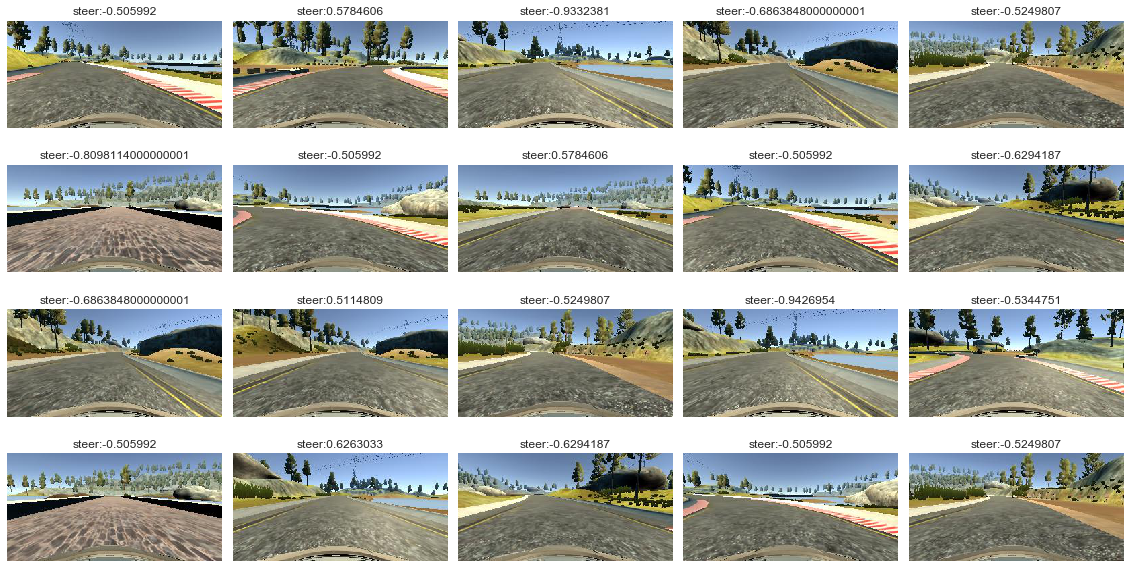

In [5]:
fig, axes = plt.subplots(4, 5, figsize=(20, 10), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
print("Udacity images visualization (big angle):")
for ax in axes.flat:
    index = np.random.randint(total)
    while abs(log.iloc[index,3]) < 0.5:
        index = np.random.randint(total)
    img = cv2.cvtColor(cv2.imread(log.iloc[index,0]),cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title('steer:{}'.format(log.iloc[index,3]))
plt.savefig('./examples/UdacityImgShow.png')
# plt.show()

Udacity images visualization (small angle):


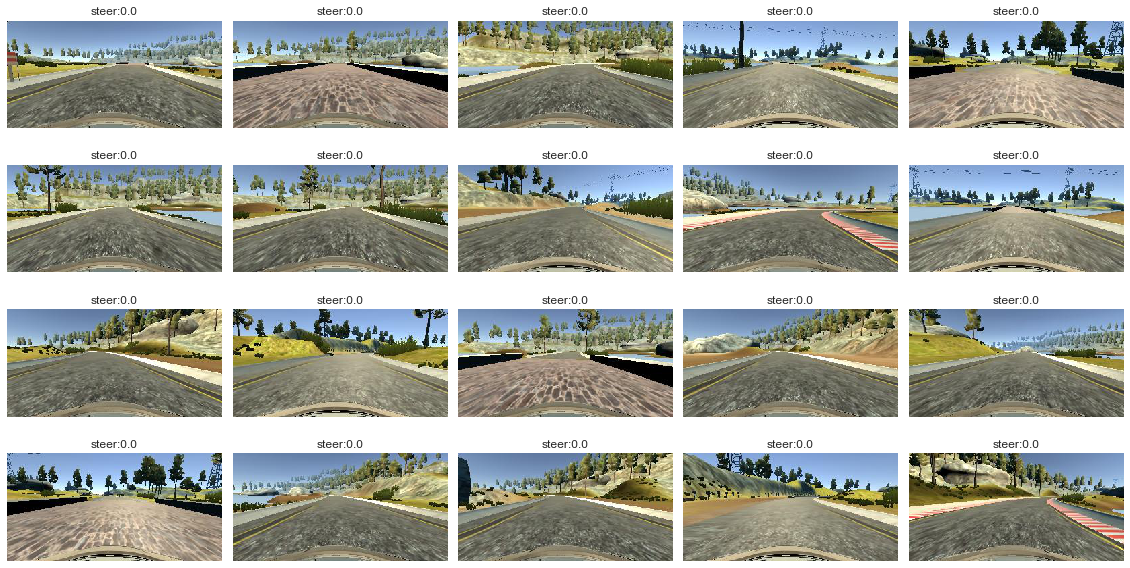

In [35]:
fig, axes = plt.subplots(4, 5, figsize=(20, 10), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
print("Udacity images visualization (small angle):")
for ax in axes.flat:
    index = np.random.randint(total)
    while abs(log.iloc[index,3]) != 0.0:
        index = np.random.randint(total)
    img = cv2.cvtColor(cv2.imread(log.iloc[index,0]),cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title('steer:{}'.format(log.iloc[index,3]))

plt.show()

Visualizing left, central, and right images, find an appropriate angle shift
Udacity images visualization:
Orig time step: 4609


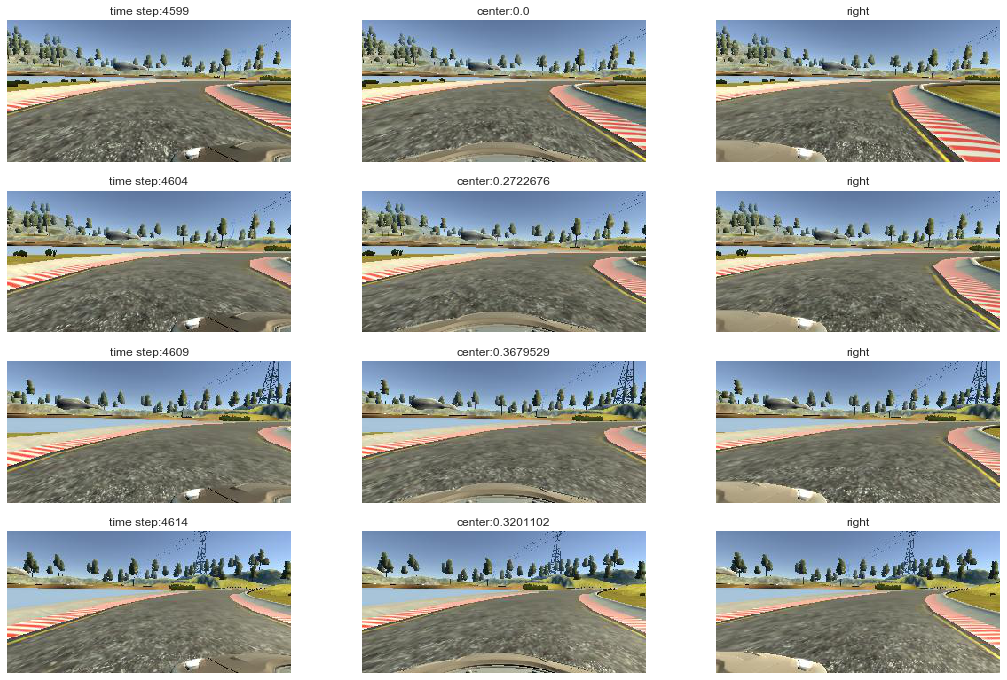

In [10]:
print("Visualizing left, central, and right images, find an appropriate angle shift")
num_steps = 4
fig, axes = plt.subplots(num_steps, 3, figsize=(18, 3*num_steps), subplot_kw={'xticks': [], 'yticks': []})
print("Udacity images visualization:")
index = 4609
print("Orig time step: {}".format(index))
start = int(-num_steps/2)
end = int(num_steps/2)
step = 5
for i in range(start,end,1):
    ind = index + i * step
    center = cv2.cvtColor(cv2.imread(log.iloc[ind,0]),cv2.COLOR_BGR2RGB)
    left = cv2.cvtColor(cv2.imread(log.iloc[ind,1]),cv2.COLOR_BGR2RGB)
    right = cv2.cvtColor(cv2.imread(log.iloc[ind,2]),cv2.COLOR_BGR2RGB)
    axes[i - start,0].imshow(left)
    axes[i - start,0].set_title('time step:{}'.format(ind))
    axes[i - start,1].imshow(center)
    axes[i - start,1].set_title('center:{}'.format(log.iloc[ind,3]))
    axes[i - start,2].imshow(right)
    axes[i - start,2].set_title('right')
plt.savefig('./examples/leftRightImages.png')
plt.show()

### shown from above, the actual steering angle is not always proportional to the needed steering (curvature). The time step 4589's angle does not make sense, as both preceeding and after images have ZERO angle. Time step 4619's angle is not between the angle of step 4614 and 4624. 

In [12]:
def augment_brightness(img1):
	img = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
	img = np.array(img, dtype = np.float64)
	light = np.random.uniform() + 0.5
	img[:,:,2] = img[:,:,2] * light
	img[:,:,2][img[:,:,2] > 255] = 255
	img = np.array(img, dtype = np.uint8)
	img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
	return img

Visualizing brightness augmentation


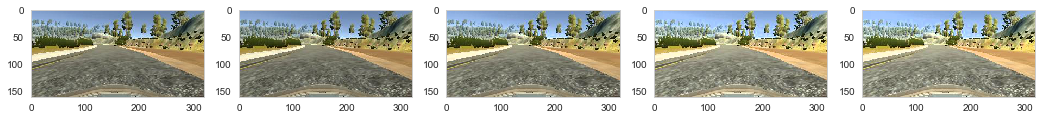

In [14]:
print('Visualizing brightness augmentation')
index = 4609
sns.set_style("whitegrid", {'axes.grid' : False})
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# img = cv2.cvtColor(cv2.imread(log.iloc[index,2]),cv2.COLOR_BGR2RGB)
# ax.imshow(img)

fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for ax in axes:
    ax.imshow(augment_brightness(img))
plt.savefig('./examples/brightnessAug.png')

In [106]:
def trans_image(image,steer,trans_range):
    # Translation
	tr_x = trans_range*np.random.uniform()-trans_range/2
	steer_ang = steer + tr_x * 0.005
	y_trans_range = 20
	tr_y = y_trans_range*np.random.uniform()-y_trans_range/2
	#tr_y = 0
	Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
	image_tr = cv2.warpAffine(image,Trans_M,(320,160))
	return image_tr,steer_ang
def trans_image2(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 20*np.random.uniform()-20/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(320,160))
    
    return image_tr,steer_ang

Visualizing trans_image augmentation


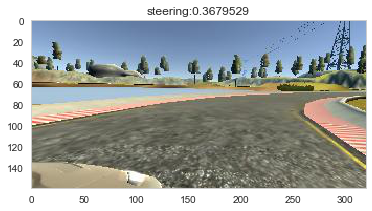

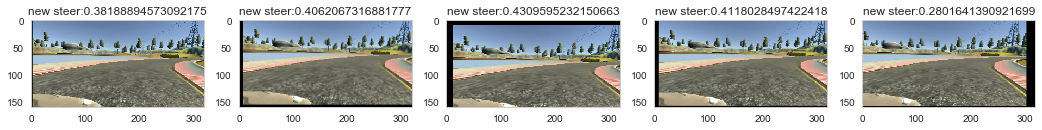

In [108]:
print('Visualizing trans_image augmentation')
index = 4609
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = cv2.cvtColor(cv2.imread(log.iloc[index,2]),cv2.COLOR_BGR2RGB)
steer = log.iloc[index,3]
ax.imshow(img)
ax.set_title('steering:{}'.format(steer))

fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for ax in axes:
    n_img, n_steer = trans_image(img, steer, 40)
    ax.imshow(n_img)
    ax.set_title('new steer:{}'.format(n_steer))

Visualizing trans_image2 augmentation


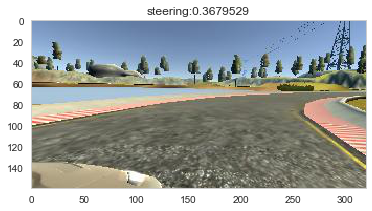

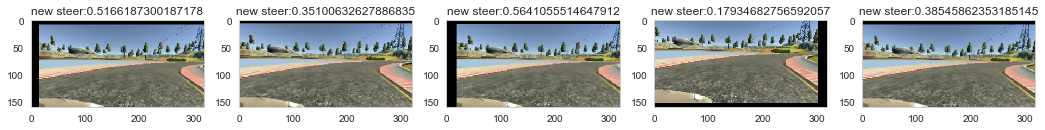

In [104]:
print('Visualizing trans_image2 augmentation')
index = 4609
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = cv2.cvtColor(cv2.imread(log.iloc[index,2]),cv2.COLOR_BGR2RGB)
steer = log.iloc[index,3]
ax.imshow(img)
ax.set_title('steering:{}'.format(steer))

fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for ax in axes:
    n_img, n_steer = trans_image2(img, steer, 40)
    ax.imshow(n_img)
    ax.set_title('new steer:{}'.format(n_steer))

In [86]:
def flip(image, steer):
    n_image = cv2.flip(image,1)
    n_steer = -steer
    return n_image, n_steer

Visualizing flip augmentation


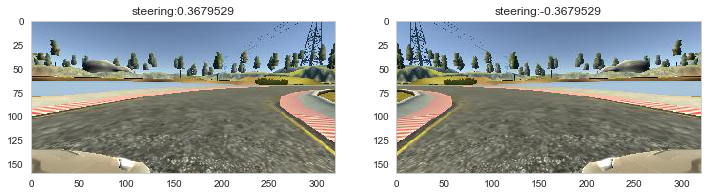

In [91]:
print('Visualizing flip augmentation')
index = 4609
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,2,1)
img = cv2.cvtColor(cv2.imread(log.iloc[index,2]),cv2.COLOR_BGR2RGB)
steer = log.iloc[index,3]
ax.imshow(img)
ax.set_title('steering:{}'.format(steer))

n_img, n_steer = flip(img, steer)
ax = fig.add_subplot(1,2,2)
ax.imshow(n_img)
ax.set_title('steering:{}'.format(n_steer))

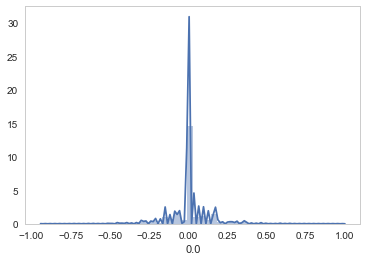

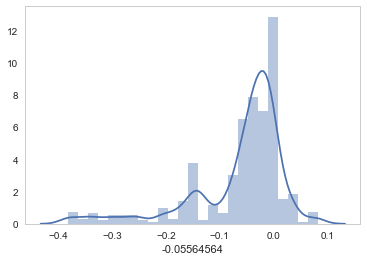

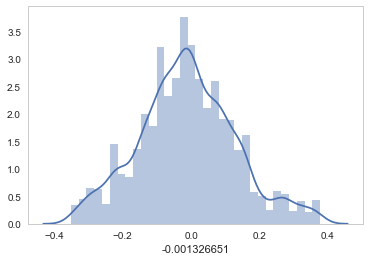

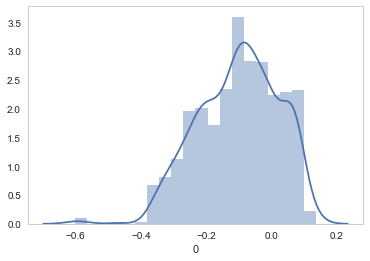

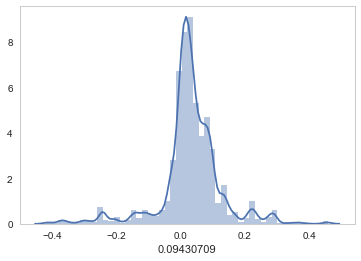

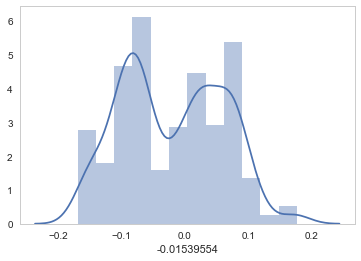

In [96]:
sns.distplot(log.iloc[:,3])
plt.figure()
sns.distplot(log_afterBridge.iloc[:,3])
plt.figure()
sns.distplot(log_afterBridge2.iloc[:,3])
plt.figure()
sns.distplot(log_afterBridge3.iloc[:,3])
plt.figure()
sns.distplot(log_reverse.iloc[:,3])
plt.figure()
sns.distplot(log_recovery.iloc[:,3])

In [97]:
print(len(log))
print(len(log_afterBridge))
print(len(log_afterBridge2))
print(len(log_afterBridge3))
print(len(log_reverse))
print(len(log_recovery))

8035
499
3459
995
2990
788


(160, 320, 3)
(66, 200, 3)


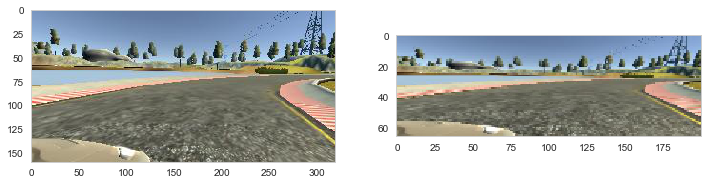

In [100]:
img = cv2.cvtColor(cv2.imread(log.iloc[index,2]),cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(1,2,1)
ax.imshow(img)
print(img.shape)
img_small = cv2.resize(img, (200,66))
ax = fig.add_subplot(1,2,2)
ax.imshow(img_small)
print(img_small.shape)